In [10]:
import sys
import os
import json

os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import mixed_precision
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.applications import MobileNetV2

# Environnement

In [2]:
mixed_precision.set_global_policy('mixed_float16')
gpus = tf.config.list_physical_devices('GPU')

ROOT_DIRECTORY = Path.cwd().parent.parent
ETUDE_DIRECTORY = ROOT_DIRECTORY / 'Projet-Etude-CNN-DeepLearning'
DATASET_DIRECTORY = ETUDE_DIRECTORY / "dataset" / "Dog-Breed-Identification"
NOTEBOOKS_DIRECTORY = ETUDE_DIRECTORY / "notebooks"
MODELS_DIRECTORY = ETUDE_DIRECTORY / "models"

TRAIN_DATASET_FOLDER_JPG = DATASET_DIRECTORY / 'train'
TEST_DATASET_FOLDER_JPG = DATASET_DIRECTORY / 'test'
FEATURES_FILE_CSV = DATASET_DIRECTORY / 'labels.csv'

MODEL_NAME = "model_dog_from_mobilenetv2"
MODEL_CHECKPOINT_PATH = MODELS_DIRECTORY / MODEL_NAME / 'checkpoints' / f"{MODEL_NAME}_checkpoint.keras"
MODEL_FINAL_PATH = MODELS_DIRECTORY / MODEL_NAME / f"{MODEL_NAME}.keras"

print(f"""
ROOT_DIRECTORY : {ROOT_DIRECTORY}
ETUDE_DIRECTORY : {ETUDE_DIRECTORY}
DATASET_DIRECTORY : {DATASET_DIRECTORY}
NOTEBOOKS_DIRECTORY : {NOTEBOOKS_DIRECTORY}
MODELS_DIRECTORY : {MODELS_DIRECTORY}
TRAIN_DATASET_FOLDER_JPG : {TRAIN_DATASET_FOLDER_JPG}
TEST_DATASET_FOLDER_JPG : {TEST_DATASET_FOLDER_JPG}
FEATURES_FILE_CSV : {FEATURES_FILE_CSV}
MODEL_NAME : {MODEL_NAME}
MODEL_CHECKPOINT_PATH: {MODEL_CHECKPOINT_PATH}
MODEL_FINAL_PATH : {MODEL_FINAL_PATH}
""")


ROOT_DIRECTORY : /home/leolchalot/Documents/Projets/CNN - Deep Learning
ETUDE_DIRECTORY : /home/leolchalot/Documents/Projets/CNN - Deep Learning/Projet-Etude-CNN-DeepLearning
DATASET_DIRECTORY : /home/leolchalot/Documents/Projets/CNN - Deep Learning/Projet-Etude-CNN-DeepLearning/dataset/Dog-Breed-Identification
NOTEBOOKS_DIRECTORY : /home/leolchalot/Documents/Projets/CNN - Deep Learning/Projet-Etude-CNN-DeepLearning/notebooks
MODELS_DIRECTORY : /home/leolchalot/Documents/Projets/CNN - Deep Learning/Projet-Etude-CNN-DeepLearning/models
TRAIN_DATASET_FOLDER_JPG : /home/leolchalot/Documents/Projets/CNN - Deep Learning/Projet-Etude-CNN-DeepLearning/dataset/Dog-Breed-Identification/train
TEST_DATASET_FOLDER_JPG : /home/leolchalot/Documents/Projets/CNN - Deep Learning/Projet-Etude-CNN-DeepLearning/dataset/Dog-Breed-Identification/test
FEATURES_FILE_CSV : /home/leolchalot/Documents/Projets/CNN - Deep Learning/Projet-Etude-CNN-DeepLearning/dataset/Dog-Breed-Identification/labels.csv
MODEL_NAM

# Configuration matérielle

In [3]:
def _():
    """
    Show the current hardware configuration
    :return:
    """
    print(f"🐍 Version Python : {sys.version.split()[0]}")
    print(f"🤖 Version TensorFlow : {tf.__version__}")

    try:
        print("\n--- État Système (nvidia-smi) ---")
        !nvidia-smi
    except Exception as rised_error:
        print(rised_error)

    print("\n--- Détection TensorFlow ---")
    if not gpus:
        print("❌ Aucun GPU détecté par TensorFlow.")
        print("Causes possibles :")
        print("1. Vous n'avez pas installé 'tensorflow[and-cuda]'")
        print("2. Votre version de Python n'est pas supportée.")
        print("3. La variable CUDA_VISIBLE_DEVICES = -1 est restée active.")
    else:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print("✅ GPU configuré : Mémoire dynamique activée")
        except RuntimeError as rised_error:
            print(f"Erreur config GPU : {rised_error}")

_()

🐍 Version Python : 3.10.19
🤖 Version TensorFlow : 2.20.0

--- État Système (nvidia-smi) ---
Fri Jan 30 09:49:57 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.126.09             Driver Version: 580.126.09     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   50C    P8              2W /   80W |      18MiB /   8188MiB |      0%      Default |
|                                         |     

# Chargement des données

In [4]:
images_train_dataset = os.listdir(TRAIN_DATASET_FOLDER_JPG)
images_test_dataset = os.listdir(TEST_DATASET_FOLDER_JPG)
labels_df = pd.read_csv(FEATURES_FILE_CSV)
print(' No# of train images in data:', len(images_train_dataset))
print(' No# of test images in data:', len(images_test_dataset))
labels_df.head()

 No# of train images in data: 10222
 No# of test images in data: 10357


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


# Variables de configuration

In [5]:
BATCH_SIZE = 32
RANDOM_SEED = 42
SHUFFLE = True
TARGET_SIZE = (224,224)

VALIDATION_SPLIT = 0.2      # 20% des données serviront à la validation
ROTATION_RANGE = 40         # Rotation aléatoire jusqu'à 20 degrés
WIDTH_SHIFT_RANGE = 0.2     # Décalage horizontal
HEIGHT_SHIFT_RANGE = 0.2    # Décalage vertical
HORIZONTAL_FLIP = True      # Retournement horizontal (miroir)
FILL_MODE = "nearest"       # Methode de remplissage des pixels "éteints"

# Reconstitution des noms des fichiers d'images
labels_df['id'] = labels_df['id'].apply(lambda x_name: x_name + ".jpg" if not x_name.endswith(".jpg") else x_name)

# print(labels_df.head())

In [6]:
# Création du générateur avec augmentation de données
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

# Configuration pour l'entraînement avec augmentation de données
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT,
    rotation_range=ROTATION_RANGE,
    width_shift_range=WIDTH_SHIFT_RANGE,
    height_shift_range=HEIGHT_SHIFT_RANGE,
    horizontal_flip=HORIZONTAL_FLIP,
    fill_mode=FILL_MODE
)

# Configuration pour la validation
valid_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Entraînement
train_generator = train_datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory=TRAIN_DATASET_FOLDER_JPG,
    x_col="id",
    y_col="breed",
    subset="training",
    batch_size=BATCH_SIZE,
    seed=RANDOM_SEED,
    shuffle=SHUFFLE,
    class_mode="categorical",
    target_size=TARGET_SIZE
)

# Validation
valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory=TRAIN_DATASET_FOLDER_JPG,
    x_col="id",
    y_col="breed",
    subset="validation",
    batch_size=BATCH_SIZE,
    seed=RANDOM_SEED,
    shuffle=SHUFFLE,
    class_mode="categorical",
    target_size=TARGET_SIZE
)

# ---- Configuration du déroulement de l'entraînement ----
# 1. Sauvegarde
checkpoint = ModelCheckpoint(MODEL_CHECKPOINT_PATH,
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)

# 2. Arrêt automatique (Patience augmentée à 8, car l'apprentissage from scratch est lent)
early_stop = EarlyStopping(monitor='val_loss',
                           patience=8,
                           restore_best_weights=True)

# 3. Ralentissement automatique (INDISPENSABLE ici)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,    # On divise le Learning Rate par 5
                              patience=3,    # Si pas d'amélioration pendant 3 époques
                              min_lr=1e-6,   # Ne pas descendre trop bas
                              verbose=1)

callbacks_list = [checkpoint, early_stop, reduce_lr]

# print(train_generator.class_indices)

Found 8178 validated image filenames belonging to 120 classes.
Found 2044 validated image filenames belonging to 120 classes.


# Architecture du modèle

In [9]:
# 1. Nettoyage de la mémoire (Important pour effacer le modèle vide précédent)
tf.keras.backend.clear_session()

# 2. Configuration
N_CLASSES = 120  # Nombre de races de chiens
INPUT_SHAPE = (224, 224, 3)

# 3. Chargement du modèle de base (MobileNetV2)
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=INPUT_SHAPE
)
base_model.trainable = False # On gèle les poids

# 4. Construction du modèle Final (Approche Séquentielle)
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(N_CLASSES, activation='softmax')
], name="DogBreedModel")

# 5. Compilation
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 6. Vérification
model.summary()

Model: "DogBreedModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │       153,720 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,411,704 (9.20 MB)

 Trainable params: 153,720 (600.47 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
# 4. Lancement (50 EPOCHS)
history = model.fit(
    train_generator,
    # steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    callbacks=callbacks_list
)

Epoch 1/50


2026-01-30 09:55:10.574889: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-30 09:55:10.659622: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


  1/256 ━━━━━━━━━━━━━━━━━━━━ 31:08 7s/step - accuracy: 0.0000e+00 - loss: 5.3934

I0000 00:00:1769763312.236325   27759 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


214/256 ━━━━━━━━━━━━━━━━━━━━ 8s 193ms/step - accuracy: 0.2011 - loss: 3.7494

2026-01-30 09:55:55.755290: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-30 09:55:55.839894: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.2259 - loss: 3.5830

2026-01-30 09:56:11.655782: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-30 09:56:11.740824: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.



Epoch 1: val_accuracy improved from None to 0.66928, saving model to /home/leolchalot/Documents/Projets/CNN - Deep Learning/Projet-Etude-CNN-DeepLearning/models/model_dog_from_mobilenetv2/checkpoints/model_dog_from_mobilenetv2_checkpoint.keras
256/256 ━━━━━━━━━━━━━━━━━━━━ 68s 240ms/step - accuracy: 0.3652 - loss: 2.6603 - val_accuracy: 0.6693 - val_loss: 1.2709 - learning_rate: 0.0010
Epoch 2/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.6007 - loss: 1.4635
Epoch 2: val_accuracy improved from 0.66928 to 0.70646, saving model to /home/leolchalot/Documents/Projets/CNN - Deep Learning/Projet-Etude-CNN-DeepLearning/models/model_dog_from_mobilenetv2/checkpoints/model_dog_from_mobilenetv2_checkpoint.keras
256/256 ━━━━━━━━━━━━━━━━━━━━ 50s 196ms/step - accuracy: 0.6010 - loss: 1.4494 - val_accuracy: 0.7065 - val_loss: 1.0418 - learning_rate: 0.0010
Epoch 3/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.6548 - loss: 1.2181
Epoch 3: val_accuracy did not improve from 0

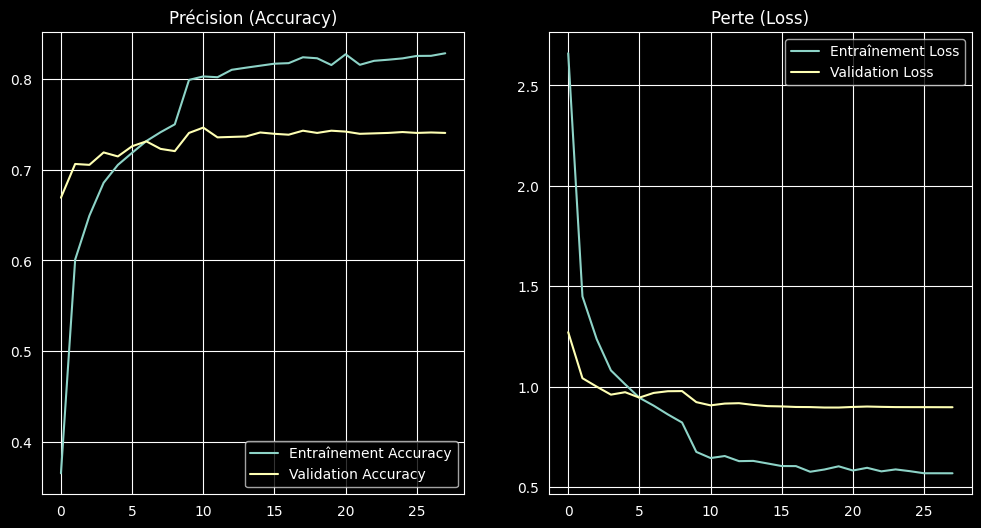

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

# Courbe de Précision
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Entraînement Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Précision (Accuracy)')

# Courbe de Perte
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Entraînement Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Perte (Loss)')
plt.show()

In [13]:
# Sauvegarde au format de Keras
model.save(MODEL_FINAL_PATH)
print("Modèle sauvegardé avec succès !")

Modèle sauvegardé avec succès !


2026-01-30 10:24:59.998383: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-30 10:25:00.080849: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


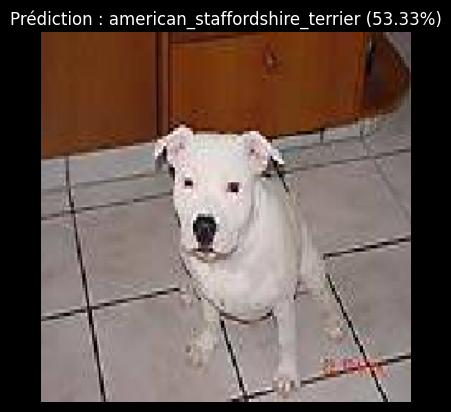

In [14]:
labels_map = {v: k for k, v in train_generator.class_indices.items()}

def predict_breed(img_path):
    # Charger l'image et la redimensionner comme à l'entraînement (224x224)
    img = image.load_img(img_path, target_size=(224, 224))

    # Convertir en tableau de nombres (array)
    img_array = image.img_to_array(img)

    # Normaliser (diviser par 255 comme lors de l'entraînement)
    img_array = img_array / 255.0

    # Ajouter une dimension pour simuler un batch de 1 image (1, 224, 224, 3)
    img_array = np.expand_dims(img_array, axis=0)

    # Faire la prédiction
    model_prediction = model.predict(img_array)

    # Trouver l'index de la probabilité la plus élevée
    predicted_class_index = np.argmax(model_prediction)
    confidence = np.max(model_prediction) * 100

    predicted_breed = labels_map[predicted_class_index]

    # Affichage
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prédiction : {predicted_breed} ({confidence:.2f}%)")
    plt.show()

# --- UTILISATION ---
# Remplacez par le chemin d'une image de votre dossier de test
test_image_path = os.path.join(TEST_DATASET_FOLDER_JPG, os.listdir(TEST_DATASET_FOLDER_JPG)[3])
predict_breed(test_image_path)

In [15]:
# Récupérer le mapping ({'beagle': 0, 'boxer': 1})
class_indices = train_generator.class_indices

# Inverser pour avoir {0: 'beagle', 1: 'boxer'}
idx_to_class = {v: k for k, v in class_indices.items()}

# Sauvegarder dans un fichier
with open(DATASET_DIRECTORY / 'class_indices.json', 'w') as f:
    json.dump(idx_to_class, f)

print("✅ Fichier class_indices.json généré !")

✅ Fichier class_indices.json généré !
